## An Example to Use our `WHYSHIFT` Package
In this example, we provide codes for getting data, fetching models, training models and diagnosing the performance degradation.

In [1]:
from whyshift import get_data, degradation_decomp, fetch_model, risk_region
import numpy as np 
import torch 
import random 

### Load Source and Target Data

In [16]:
source_X_raw, source_y_raw, feature_names = get_data("income", "CA", False, './datasets/acs/', 2018)
target_X, target_y, feature_names = get_data("income", "AL", False, './datasets/acs/', 2018)

### Generate Train/Validation Set for the source distribution

In [17]:
num_samples = 20000
if source_X_raw.shape[0]>=2*num_samples:
    perm2 = np.random.permutation(source_X_raw.shape[0])
    source_X = source_X_raw[perm2[:num_samples],:]
    source_y = source_y_raw[perm2[:num_samples]]
    source_X_train = source_X_raw[perm2[num_samples:2*num_samples],:]
    source_y_train = source_y_raw[perm2[num_samples:2*num_samples]]
else:
    perm2 = np.random.permutation(source_X_raw.shape[0])
    source_X = source_X_raw[perm2[:int(0.5*source_X_raw.shape[0])],:]
    source_y = source_y_raw[perm2[:int(0.5*source_X_raw.shape[0])]]
    source_X_train = source_X_raw[perm2[int(0.5*source_X_raw.shape[0]):],:]
    source_y_train = source_y_raw[perm2[int(0.5*source_X_raw.shape[0]):]]

### Fetch model and train
* Implemented methods include: `Logistic Regression`, `MLP`, `SVM`, `Random Forest`, `XGBoost`, `LightGBM`, `GBM`, $\chi^2$/CVaR-`DRO/DORO`, `Group DRO`, `Simple-Reweighting`, `JTT`, `Fairness-In/Postprocess` and `DWR` methods.
* Supported names in the `fetch_model` function are: 
```python
 ['lr','svm','xgb', 'lightgbm', 'rf',  'dwr', 'jtt','suby', 'subg', 'rwy', 'rwg', 'FairPostprocess_exp','FairInprocess_dp', 'FairPostprocess_threshold', 'FairInprocess_eo', 'FairInprocess_error_parity','chi_dro', 'chi_doro','cvar_dro','cvar_doro','group_dro']
```

In [18]:
model = fetch_model('xgb')
model.fit(source_X_train, source_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Performance degradation decomposition via DISDE

In [19]:
p2p, q2q, p2s, s2q = degradation_decomp(source_X, source_y, target_X, target_y, model, data_sum=20000, K=8, draw_calibration=False, save_calibration_png='calibration.png')
print(f"Total Performance Degradation is {p2p-q2q}")
print(f"Proportion of Y|X-shift is {(p2s-s2q)/(p2p-q2q)}")

Total Performance Degradation is 0.04785000000000006
Proportion of Y|X-shift is 0.6353269442472409


### Identify the Risk Region

In [3]:
import xgboost as xgb

source_model = xgb.XGBClassifier()
target_model = xgb.XGBClassifier()
risk_region('xgb', source_model, target_model, 'income', 'CA', 'PR', "/home/jiashuoliu/TabularWilds/src/datasets/acs")

source model state CA acc is 0.8478
source model state PR acc is 0.7145
tgt model state CA acc is 0.6783
tgt model state PR acc is 0.9522


### Draw decomposition figure

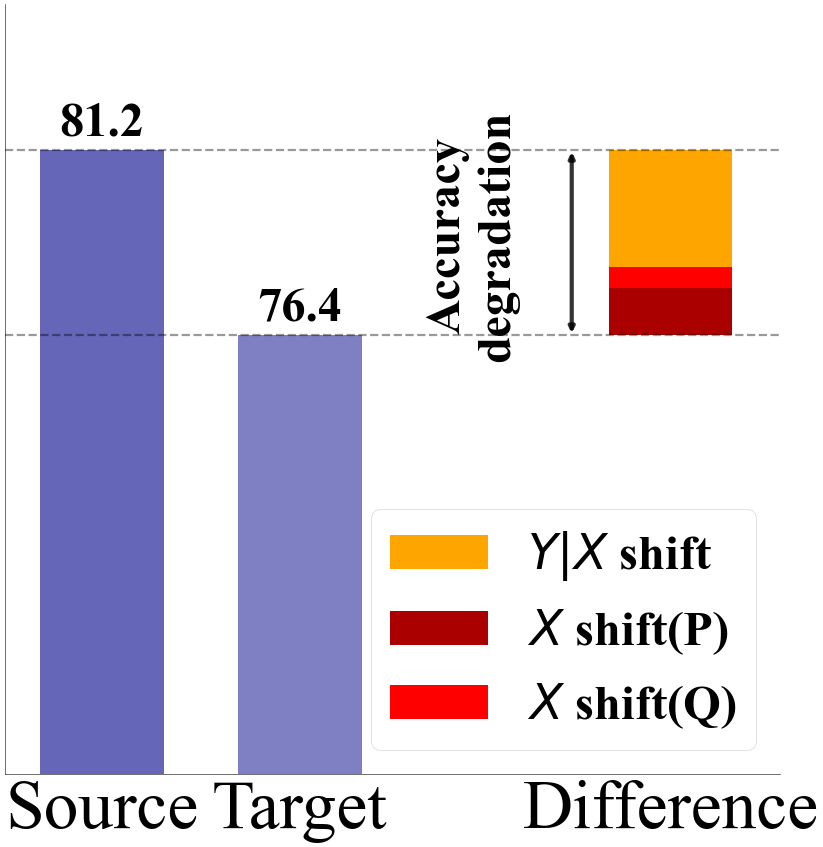

In [21]:
import matplotlib.pyplot as plt 

fig, subax = plt.subplots(figsize=(20,20), dpi=50)
plt.rcParams['font.family'] = 'Times New Roman'
colors = ['#DC143C', '#0000CD', '#66CDAA', '#DC143C']
bar1 = subax.bar([0.0], [p2p], width=0.5, color='darkblue', alpha=0.6)[0]
subax.text(bar1.get_x() + bar1.get_width() / 2,
        bar1.get_height()*1.005,
        "%.1f"%(p2p*100),
        horizontalalignment='center',
        weight='bold', fontsize=70)

bar2 = subax.bar([0.8], [q2q], width=0.5, color='darkblue', alpha=0.5)[0]
subax.text(bar2.get_x() + bar2.get_width() / 2,
        bar2.get_height()*1.005,
        "%.1f"%(q2q*100),
        horizontalalignment='center',
        weight='bold', fontsize=70)
subax.bar([2.3], [p2s-s2q], width=0.5, bottom=p2p-(p2s-s2q), color='orange', label=r"$Y|X$ shift")
subax.bar([2.3], [p2p-p2s], width=0.5, bottom=q2q, color='#AA0000', label=r"$X$ shift(P)")
subax.bar([2.3], [s2q-q2q], width=0.5, bottom=(p2p-p2s)+q2q, color='red', label=r"$X$ shift(Q)")
subax.bar([2.3], [q2q], width=0.6, bottom=0, color='white')
subax.set_ylim([0.65, 0.85])
subax.set_xticks([0.0,0.8,2.3], ["Source", "Target", "Difference"], fontsize=100)
for label in subax.get_xticklabels():
    label.set_fontname('Times New Roman')
subax.spines['top'].set_visible(False)
subax.spines['right'].set_visible(False)
subax.tick_params(bottom=False, left=False)
subax.set_axisbelow(True)
subax.xaxis.grid(False)
subax.legend(loc='lower right', ncol=1, prop= {'weight':'bold', 'size':70})
subax.set_yticks([], [], fontsize=30)
subax.axhline(q2q, linestyle='dashed', color='black', alpha=0.4, linewidth=3.2)
subax.axhline(p2p, linestyle='dashed', color='black', alpha=0.4, linewidth=3.2)
subax.annotate(text='', xy=(1.9,q2q),
             xytext=(1.9,p2p),
             arrowprops=dict(arrowstyle='<|-|>',
                             color='black',
                             mutation_scale=15,
                             alpha=0.8,lw=6))
subax.text(1.5, (p2p+q2q)/2+0.002, 'Accuracy\ndegradation', rotation='vertical', va='center', ha='center', fontsize=70, weight='bold')
plt.savefig('./decomposition.pdf',bbox_inches='tight')